# Deep Alignment Network 中使用的变换

## 1. 如何align两个shapes (landmarks)

目标：将源shape经过旋转、放缩、平移后，尽可能拟合目标shape。

采用 ASM 中的方法，可以参考文章《[An Introduction to Active Shape Models](http://www2.compute.dtu.dk/courses/02511/docs/asm_overview.pdf)》中的描述。

公式(5)：

假设源shape为 $S_1$，目标shape为 $S_2$，旋转角度为 $\theta$，放缩大小为 $s$，每个点平移 $(X_t,Y_t)$。

$$
\begin{pmatrix}
x_2\\
y_2\\
\end{pmatrix}=
\begin{pmatrix}
X_t\\
Y_t\\
\end{pmatrix}+
\begin{pmatrix}
{s \cos \theta} & {- s \sin \theta}\\
{s \sin \theta} & {s \cos \theta}\\
\end{pmatrix}
\begin{pmatrix}
x_1\\
y_1\\
\end{pmatrix}
$$

附录D：

$$
s \cos \theta = (S_1 \cdot S_2) / \left|S_1\right|^2
$$

$$
s \sin \theta = \left( \sum_{i=1}^{n}{(x_{1i}y_{2i}-y_{1i}x_{2i})} \right) / \left|S_1\right|^2
$$

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import face_alignment
import tensorflow as tf
import itertools

%matplotlib inline

### 读取数据

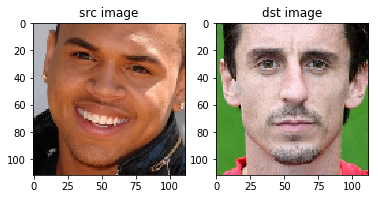

In [2]:
img_src = cv2.resize(cv2.imread('src.jpg'), (112,112))[:,:,::-1]
img_dst = cv2.resize(cv2.imread('dst.jpg'), (112,112))[:,:,::-1]

plt.subplot(121); plt.imshow(img_src)
plt.title('src image')
plt.subplot(122); plt.imshow(img_dst)
plt.title('dst image')
plt.show()

### 使用face_alignment库检测landmarks

In [3]:
fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, device='cpu')

shape_src = fa.get_landmarks(img_src)[0]
shape_dst = fa.get_landmarks(img_dst)[0]

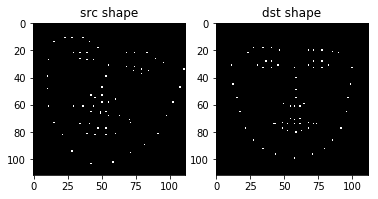

In [4]:
plot_src = np.zeros((112,112), dtype=np.uint8)
plot_dst = np.zeros((112,112), dtype=np.uint8)

for i in range(68):
    plot_src[int(shape_src[i][1])][int(shape_src[i][0])] = 255
plt.subplot(121); plt.imshow(plot_src, cmap='gray')
plt.title('src shape')

for i in range(68):
    plot_dst[int(shape_dst[i][1])][int(shape_dst[i][0])]= 255
plt.subplot(122); plt.imshow(plot_dst, cmap='gray')
plt.title('dst shape')

plt.show()

### 计算旋转放缩矩阵 A 和平移矩阵 T

In [5]:
# 计算shape中所有点的平均中心坐标
mean_src = np.mean(shape_src, axis=0)
mean_dst = np.mean(shape_dst, axis=0)

# 将shape中心化
center_src = shape_src - mean_src
center_dst = shape_dst - mean_dst

# 平坦化
vec_src = center_src.flatten()
vec_dst = center_dst.flatten()

# |S1|^2
norm = np.linalg.norm(vec_src) ** 2

# s*cos = s1*s2 / |S1|^2
a = np.dot(vec_src,vec_dst) / norm

# s*sin = (x1*y2 - y1*x2) / |S1|^2
b = (np.dot(center_src[:,0],center_dst[:,1]) - np.dot(center_src[:,1],center_dst[:,0])) / norm

# 与原公式不同的是，这里将变换矩阵写为右乘的形式[[a,b],[-b,a]]
A = np.asarray([[a,b],[-b,a]])

# 计算平移量
mean_transf_src = np.dot(mean_src, A)
T = mean_dst - mean_transf_src

### 对源 shape 进行变换

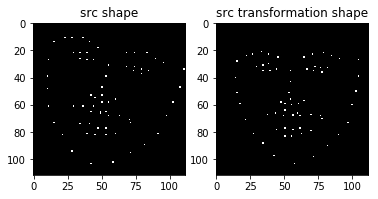

In [6]:
shape_src_transf = np.dot(shape_src, A) + T

plot_transf_src = np.zeros((112,112), dtype=np.uint8)
for i in range(68):
    plot_transf_src[int(shape_src_transf[i][1])][int(shape_src_transf[i][0])] = 1

plt.subplot(121); plt.imshow(plot_src, cmap='gray')
plt.title('src shape')
plt.subplot(122); plt.imshow(plot_transf_src, cmap='gray')
plt.title('src transformation shape')

plt.show()

## 2. 根据变换矩阵对源图像进行校正

In [7]:
img_src_gray = cv2.cvtColor(img_src, cv2.COLOR_BGR2GRAY).astype(np.float32)  # DAN中使用灰度图

In [8]:
Pixels = np.array([(x, y) for x in range(112) for y in range(112)], dtype=np.float32).reshape((112,112,2))

A_ = np.linalg.inv(A)
T_ = np.dot(-T, A_)[::-1]
A_ = A_.T

SrcPixels = np.dot(Pixels.reshape((112*112, 2)), A_) + T_
SrcPixels = np.clip(SrcPixels, 0, 112-2)
outPixelsMinMin = SrcPixels.astype(np.int32).astype(np.float64)
dxdy = SrcPixels - outPixelsMinMin
dx = dxdy[:, 0]
dy = dxdy[:, 1]

outPixelsMinMin = outPixelsMinMin.astype(np.int32).reshape((112*112, 2))
outPixelsMaxMin = outPixelsMinMin + [1, 0]
outPixelsMinMax = outPixelsMinMin + [0, 1]
outPixelsMaxMax = outPixelsMinMin + [1, 1]

img_src_transf = (1-dx)*(1-dy)*img_src_gray[outPixelsMinMin[:, 0], outPixelsMinMin[:, 1]] \
+ dx*(1-dy)*img_src_gray[outPixelsMaxMin[:, 0], outPixelsMaxMin[:, 1]] \
+ (1-dx)*dy * img_src_gray[outPixelsMinMax[:, 0], outPixelsMinMax[:, 1]] \
+ dx*dy*img_src_gray[outPixelsMaxMax[:, 0], outPixelsMaxMax[:, 1]]

img_src_transf = img_src_transf.reshape((112,112))

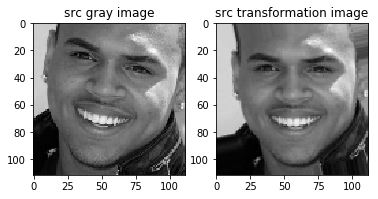

In [9]:
plt.subplot(121); plt.imshow(img_src_gray, cmap='gray')
plt.title('src gray image')
plt.subplot(122); plt.imshow(img_src_transf, cmap='gray')
plt.title('src transformation image')
plt.show()

## 3. 根据shape画heatmap

In [10]:
half_size = 8

# offsets =
# [[[-8,-8], [-8,-7], ..., [-8,7]],
#  [[-7,-8], [-7,-7], ..., [-7,7]],
#  ...,
#  [[7, -8], [7, -7], ..., [7, 7]]]

offsets = np.array(list(itertools.product(range(-half_size, half_size),
                                          range(-half_size, half_size))), dtype=np.int32).reshape((16, 16, 2))

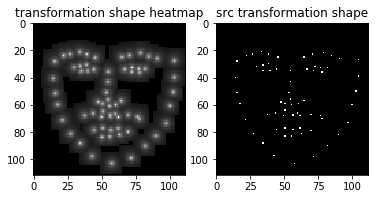

In [11]:
heatmap = np.zeros((68,112,112), dtype=np.float32)

landmarks = shape_src_transf.reshape((68,2))[:,::-1]
landmarks = np.clip(landmarks, half_size, 112 - 1 - half_size)
landmarks_int = landmarks.astype(np.int32)

for i in range(68):
    locations = offsets + landmarks_int[i]  # 坐标周围的256个点
    dxdy = landmarks[i] - landmarks_int[i].astype(np.float32)  # 坐标的小数部分
    offsets_subpix = offsets.astype(np.float32) - dxdy
    vals = 1 / (1 + np.linalg.norm(offsets_subpix, axis=2))
    locations = locations.reshape((16*16, 2))
    vals = vals.reshape((16*16,))
    heatmap[i, locations[:,0], locations[:,1]] = vals
heatmap = np.max(heatmap, axis=0)

plt.subplot(121); plt.imshow(heatmap, cmap='gray')
plt.title('transformation shape heatmap')
plt.subplot(122); plt.imshow(plot_transf_src, cmap='gray')
plt.title('src transformation shape')
plt.show()